In [1]:
import os
os.chdir('../')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt

import functional as F

In [3]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

In [4]:
n_class = 5
n_features = 32
n_samples = 100
eps = 0.5
mu = 0.1
features = torch.randn(n_samples, n_features).float() # shape: (n_samples, n_features)
features = tF.normalize(features)
labels = torch.randint(0, n_class, size=(n_samples, ))
membership = label_to_membership(labels)

## True MCR2 loss

In [5]:
def true_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def true_loss_compress(Z, Pi, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi = Pi[:, j].sum()
        scalar = d / (trPi * eps)
        log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
        compress_loss += trPi / (2 * n) * log_det
    return compress_loss

In [6]:
true_R = true_loss_discrimn(features.T, eps)
true_Rc = true_loss_compress(features.T, membership, eps)
true_dR = true_R - true_Rc
true_dR, true_R, true_Rc

(tensor(3.9203), tensor(16.4722), tensor(12.5519))

## First Variational Form

In [7]:
def optimal_Us(Z, Pi):
    Us = []
    for j in range(Pi.shape[1]):
        U, S, V = torch.linalg.svd(Z @ Pi[:, j].diag() @ Z.T)
        Us.append(U @ (S**0.5).diag())
    return torch.stack(Us)

true_Us = optimal_Us(features.T, membership)

In [8]:
def var_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def var_loss_compress(Z, Pi, Us, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi_j = Pi[:, j].sum()
        scalar_j = trPi_j / (2 * n)
        norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
        compress_loss += scalar_j * torch.log(1 + d / (trPi_j * eps) * norms).sum()
    return compress_loss

def var_reg_U(Z, Pi, Us):
    loss_reg = 0.
    for j in range(Pi.shape[1]):
        loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro')
    return loss_reg

In [9]:
Us = torch.randn(n_class, n_features, n_features)
true_Us = optimal_Us(features.T, membership)
Us = true_Us
var_R = var_loss_discrimn(features.T, eps)
var_Rc = var_loss_compress(features.T, membership, Us, eps)
var_Rreg_U = var_reg_U(features.T, membership, Us)
var_dR = var_R - var_Rc - mu * var_Rreg_U
var_dR, var_R, var_Rc, var_Rreg_U

(tensor(3.9203), tensor(16.4722), tensor(12.5519), tensor(2.0447e-05))

In [10]:
class MCR2Variational(nn.Module):
    """Equation 9 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, Us):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        for j in range(Pi.shape[1]):
            trPi_j = Pi[:, j].sum()
            scalar_j = trPi_j / (2 * n)
            norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
            compress_loss += scalar_j * torch.log(1 + d / (trPi_j * self.eps) * norms).sum()
        return compress_loss

    def reg_U(self, Z, Pi, Us):
        loss_reg = 0.
        for j in range(Pi.shape[1]):
            loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro') ** 2
        return 0.5 * loss_reg
    
    def forward(self, Z, Pi, Us):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, Us)
        loss_reg_U = self.mu * self.reg_U(Z.T, Pi, Us)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

In [11]:
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr2var(features, membership, true_Us)

(tensor(-3.9203), tensor(16.4722), tensor(12.5519), tensor(4.4750e-12))

## Verification

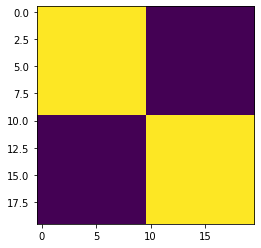

In [14]:
Z_train = torch.zeros(20, 10).float()
Z_train[:10, :5] = 1.
Z_train[10:, 5:] = 1.
Z_train = F.normalize(Z_train)
plt.imshow(Z_train @ Z_train.T)

In [15]:
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.

In [16]:
eps = 0.5
mu = 5.

criterion_mcr2var = MCR2Variational(eps, mu)
true_Us = optimal_Us(Z_train.T, Pi)
Us = nn.Parameter(
#     true_Us,
    torch.randn(2, 10, 10) / 100,
    requires_grad=True
    )
import torch.optim as optim
optimizer_Us = optim.SGD([Us], lr=0.005)

In [17]:
for epoch in range(4000):
    optimizer_Us.zero_grad()
    loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_train, Pi, Us)
    print(epoch, -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
    loss_obj.backward()
    optimizer_Us.step()

0 -497.455810546875 2.397895336151123 0.013314971700310707 499.84039306640625
1 -497.2603759765625 2.397895336151123 0.015162397176027298 499.6430969238281
2 -496.82403564453125 2.397895336151123 0.01942996308207512 499.2025146484375
3 -495.85052490234375 2.397895336151123 0.029063420370221138 498.2193603515625
4 -493.68316650390625 2.397895336151123 0.05048861727118492 496.03057861328125
5 -488.8789367675781 2.397895336151123 0.09732137620449066 491.17950439453125
6 -478.3377685546875 2.397895336151123 0.1967359483242035 480.5389404296875
7 -455.7298278808594 2.397895336151123 0.39695116877555847 457.73077392578125
8 -409.6306457519531 2.397895336151123 0.7667127251625061 411.2618408203125
9 -325.3655090332031 2.397895336151123 1.3682076930999756 326.39520263671875
10 -202.12342834472656 2.397895336151123 2.1909148693084717 202.33041381835938
11 -81.48680877685547 2.397895336151123 3.075533390045166 80.80917358398438
12 -16.53970718383789 2.397895336151123 3.7422220706939697 15.195380

131 -1.347657322883606 2.397895336151123 3.7434298992156982 0.0021227069664746523
132 -1.3446260690689087 2.397895336151123 3.740403652191162 0.002117803320288658
133 -1.3415955305099487 2.397895336151123 3.7373781204223633 0.0021128009539097548
134 -1.3385655879974365 2.397895336151123 3.7343530654907227 0.0021078959107398987
135 -1.3355361223220825 2.397895336151123 3.7313284873962402 0.0021029405761510134
136 -1.3325071334838867 2.397895336151123 3.728304386138916 0.002098062075674534
137 -1.3294789791107178 2.397895336151123 3.725281238555908 0.002093082759529352
138 -1.3264515399932861 2.397895336151123 3.7222585678100586 0.0020882561802864075
139 -1.3234245777130127 2.397895336151123 3.7192366123199463 0.0020832885056734085
140 -1.320398211479187 2.397895336151123 3.716215133666992 0.0020784493535757065
141 -1.3173726797103882 2.397895336151123 3.7131943702697754 0.0020736034493893385
142 -1.3143478631973267 2.397895336151123 3.710174560546875 0.0020686958450824022
143 -1.3113242

280 -0.914289116859436 2.397895336151123 3.310699462890625 0.0014849856961518526
281 -0.91157466173172 2.397895336151123 3.3079886436462402 0.0014813360758125782
282 -0.9088638424873352 2.397895336151123 3.305281400680542 0.0014777774922549725
283 -0.9061564207077026 2.397895336151123 3.302577495574951 0.0014742834027856588
284 -0.9034518003463745 2.397895336151123 3.2998764514923096 0.0014706701040267944
285 -0.9007510542869568 2.397895336151123 3.2971792221069336 0.0014671669341623783
286 -0.8980529308319092 2.397895336151123 3.2944846153259277 0.0014636690029874444
287 -0.8953588604927063 2.397895336151123 3.2917940616607666 0.001460131024941802
288 -0.8926676511764526 2.397895336151123 3.2891063690185547 0.0014566279714927077
289 -0.8899800181388855 2.397895336151123 3.2864222526550293 0.00145310431253165
290 -0.8872957825660706 2.397895336151123 3.2837414741516113 0.0014496196527034044
291 -0.8846148252487183 2.397895336151123 3.281064033508301 0.0014461198588833213
292 -0.8819370

431 -0.544575035572052 2.397895336151123 2.941424608230591 0.0010457716416567564
432 -0.5424023866653442 2.397895336151123 2.9392542839050293 0.0010434574214741588
433 -0.5402333736419678 2.397895336151123 2.9370875358581543 0.0010411893017590046
434 -0.538067638874054 2.397895336151123 2.9349241256713867 0.0010388753144070506
435 -0.5359058380126953 2.397895336151123 2.9327645301818848 0.0010366422357037663
436 -0.5337473154067993 2.397895336151123 2.9306082725524902 0.00103440647944808
437 -0.5315921306610107 2.397895336151123 2.928455352783203 0.001032124855555594
438 -0.5294407606124878 2.397895336151123 2.9263062477111816 0.001029867329634726
439 -0.527292788028717 2.397895336151123 2.9241604804992676 0.0010276655666530132
440 -0.5251485705375671 2.397895336151123 2.922018527984619 0.0010253991931676865
441 -0.5230078101158142 2.397895336151123 2.919879913330078 0.0010232202475890517
442 -0.5208702683448792 2.397895336151123 2.9177446365356445 0.0010209812317043543
443 -0.51873660

572 -0.2695477306842804 2.397895336151123 2.6666550636291504 0.0007880094926804304
573 -0.2677844166755676 2.397895336151123 2.66489315032959 0.0007865962106734514
574 -0.2660236954689026 2.397895336151123 2.6631338596343994 0.0007851723930798471
575 -0.26426491141319275 2.397895336151123 2.661376476287842 0.0007837588782422245
576 -0.26250776648521423 2.397895336151123 2.659620761871338 0.0007823306368663907
577 -0.2607525885105133 2.397895336151123 2.657866954803467 0.0007809610106050968
578 -0.258999228477478 2.397895336151123 2.6561150550842285 0.0007795140845701098
579 -0.25724783539772034 2.397895336151123 2.654365062713623 0.0007781200110912323
580 -0.25549861788749695 2.397895336151123 2.6526172161102295 0.00077673455234617
581 -0.253751277923584 2.397895336151123 2.6508712768554688 0.0007753519457764924
582 -0.25200560688972473 2.397895336151123 2.6491270065307617 0.0007739252760075033
583 -0.2502613961696625 2.397895336151123 2.6473841667175293 0.0007725723553448915
584 -0.24

707 -0.04297393932938576 2.397895336151123 2.4402434825897217 0.0006257925997488201
708 -0.04133644327521324 2.397895336151123 2.4386069774627686 0.0006248020799830556
709 -0.03969858959317207 2.397895336151123 2.4369702339172363 0.0006236922927200794
710 -0.03806103393435478 2.397895336151123 2.435333728790283 0.0006226403056643903
711 -0.03642373904585838 2.397895336151123 2.433697462081909 0.0006216148613020778
712 -0.03478596359491348 2.397895336151123 2.432060718536377 0.0006205797544680536
713 -0.033148422837257385 2.397895336151123 2.430424213409424 0.0006195442983880639
714 -0.03151089698076248 2.397895336151123 2.4287877082824707 0.0006185236270539463
715 -0.029873350635170937 2.397895336151123 2.4271512031555176 0.0006174839800223708
716 -0.028235776349902153 2.397895336151123 2.4255146980285645 0.0006164139485917985
717 -0.026597796007990837 2.397895336151123 2.423877716064453 0.0006154158618301153
718 -0.024960489943623543 2.397895336151123 2.422241449356079 0.0006143761565

837 0.17160898447036743 2.397895336151123 2.225789785385132 0.0004965718253515661
838 0.17327770590782166 2.397895336151123 2.2241220474243164 0.0004955780459567904
839 0.1749468296766281 2.397895336151123 2.2224538326263428 0.0004946783883497119
840 0.17661558091640472 2.397895336151123 2.2207860946655273 0.0004936541663482785
841 0.17828498780727386 2.397895336151123 2.2191176414489746 0.0004927118425257504
842 0.1799544095993042 2.397895336151123 2.217449188232422 0.0004917432088404894
843 0.18162432312965393 2.397895336151123 2.215780258178711 0.0004907510592602193
844 0.18329420685768127 2.397895336151123 2.214111328125 0.0004898071056231856
845 0.18496409058570862 2.397895336151123 2.212442398071289 0.0004888534313067794
846 0.18663400411605835 2.397895336151123 2.210773468017578 0.0004878585459664464
847 0.1883043646812439 2.397895336151123 2.209104061126709 0.00048690737457945943
848 0.18997496366500854 2.397895336151123 2.2074344158172607 0.00048595701809972525
849 0.191645562

973 0.39735549688339233 2.397895336151123 2.000171661376953 0.00036817524232901633
974 0.3989774286746979 2.397895336151123 1.9985506534576416 0.00036725157406181097
975 0.4005981385707855 2.397895336151123 1.9969308376312256 0.0003663469688035548
976 0.40221741795539856 2.397895336151123 1.9953124523162842 0.00036546343471854925
977 0.4038357436656952 2.397895336151123 1.9936950206756592 0.000364557170541957
978 0.4054531455039978 2.397895336151123 1.9920785427093506 0.0003636439214460552
979 0.4070690870285034 2.397895336151123 1.9904634952545166 0.0003627427213359624
980 0.4086843430995941 2.397895336151123 1.98884916305542 0.0003618313930928707
981 0.41029778122901917 2.397895336151123 1.9872366189956665 0.000360948673915118
982 0.4119105041027069 2.397895336151123 1.9856247901916504 0.00036003548302687705
983 0.41352179646492004 2.397895336151123 1.9840143918991089 0.0003591526474338025
984 0.4151321351528168 2.397895336151123 1.9824049472808838 0.0003582565695978701
985 0.4167409

1111 0.6044392585754395 2.397895336151123 1.7932016849517822 0.00025436305440962315
1112 0.6057670712471008 2.397895336151123 1.791874647140503 0.0002536397660151124
1113 0.6070916652679443 2.397895336151123 1.790550708770752 0.0002529594930820167
1114 0.60841304063797 2.397895336151123 1.7892301082611084 0.00025219860253855586
1115 0.6097311973571777 2.397895336151123 1.7879126071929932 0.0002515138185117394
1116 0.6110458374023438 2.397895336151123 1.7865986824035645 0.0002508160541765392
1117 0.6123576164245605 2.397895336151123 1.785287618637085 0.0002501039416529238
1118 0.6136658191680908 2.397895336151123 1.783980131149292 0.0002494151995051652
1119 0.6149709224700928 2.397895336151123 1.7826757431030273 0.0002486882440280169
1120 0.6162728667259216 2.397895336151123 1.781374454498291 0.0002480073308106512
1121 0.6175712943077087 2.397895336151123 1.7800767421722412 0.0002472967316862196
1122 0.6188666820526123 2.397895336151123 1.7787820100784302 0.00024663723888807
1123 0.6201

1235 0.7417086958885193 2.397895336151123 1.6560046672821045 0.00018199020996689796
1236 0.742576539516449 2.397895336151123 1.655137300491333 0.0001814997522160411
1237 0.7434402704238892 2.397895336151123 1.6542739868164062 0.0001810870599001646
1238 0.7443004250526428 2.397895336151123 1.653414249420166 0.0001806488144211471
1239 0.7451563477516174 2.397895336151123 1.6525588035583496 0.00018018964328803122
1240 0.7460085153579712 2.397895336151123 1.6517070531845093 0.00017974911315832287
1241 0.7468566298484802 2.397895336151123 1.6508593559265137 0.00017932633636519313
1242 0.747701108455658 2.397895336151123 1.6500153541564941 0.0001788586814654991
1243 0.7485415935516357 2.397895336151123 1.6491752862930298 0.00017843842215370387
1244 0.7493782639503479 2.397895336151123 1.648339033126831 0.00017801714420784265
1245 0.7502110004425049 2.397895336151123 1.6475067138671875 0.00017759873298928142
1246 0.7510397434234619 2.397895336151123 1.6466784477233887 0.00017714162822812796
1

1363 0.8229827284812927 2.397895336151123 1.5747723579406738 0.00014023715630173683
1364 0.8234044313430786 2.397895336151123 1.5743508338928223 0.0001400530309183523
1365 0.823823094367981 2.397895336151123 1.573932409286499 0.00013981293886899948
1366 0.8242391347885132 2.397895336151123 1.573516607284546 0.00013960701471660286
1367 0.8246520161628723 2.397895336151123 1.573103904724121 0.00013939508062321693
1368 0.8250623345375061 2.397895336151123 1.5726938247680664 0.00013918353943154216
1369 0.8254697918891907 2.397895336151123 1.572286605834961 0.00013896601740270853
1370 0.8258745670318604 2.397895336151123 1.5718820095062256 0.0001387667580274865
1371 0.8262763619422913 2.397895336151123 1.571480393409729 0.00013856029545422643
1372 0.8266755938529968 2.397895336151123 1.5710813999176025 0.00013836122525390238
1373 0.827072024345398 2.397895336151123 1.5706851482391357 0.00013815294369123876
1374 0.827465832233429 2.397895336151123 1.570291519165039 0.00013796437997370958
137

1492 0.8582406044006348 2.397895336151123 1.5395324230194092 0.00012230688298586756
1493 0.8583970665931702 2.397895336151123 1.5393760204315186 0.0001222373393829912
1494 0.8585522174835205 2.397895336151123 1.539220929145813 0.00012216938193887472
1495 0.858705997467041 2.397895336151123 1.539067268371582 0.00012208592670504004
1496 0.8588586449623108 2.397895336151123 1.538914680480957 0.00012200932542327791
1497 0.859009861946106 2.397895336151123 1.5387635231018066 0.00012193810107419267
1498 0.8591597080230713 2.397895336151123 1.5386137962341309 0.00012183948274469003
1499 0.8593085408210754 2.397895336151123 1.5384650230407715 0.00012177223106846213
1500 0.8594557046890259 2.397895336151123 1.5383179187774658 0.00012170866830274463
1501 0.8596019148826599 2.397895336151123 1.5381717681884766 0.00012164546205895022
1502 0.8597468733787537 2.397895336151123 1.5380269289016724 0.00012155817239545286
1503 0.8598905801773071 2.397895336151123 1.5378832817077637 0.0001214938602061010

1621 0.870405375957489 2.397895336151123 1.5273737907409668 0.00011617464770097286
1622 0.8704552054405212 2.397895336151123 1.5273239612579346 0.00011614130198722705
1623 0.8705043792724609 2.397895336151123 1.5272748470306396 0.00011611939407885075
1624 0.8705533742904663 2.397895336151123 1.5272258520126343 0.00011610158253461123
1625 0.8706017136573792 2.397895336151123 1.5271775722503662 0.000116072224045638
1626 0.8706498742103577 2.397895336151123 1.5271294116973877 0.00011604982137214392
1627 0.8706973195075989 2.397895336151123 1.5270819664001465 0.0001160399115178734
1628 0.8707443475723267 2.397895336151123 1.5270349979400635 0.00011600547441048548
1629 0.8707910776138306 2.397895336151123 1.5269882678985596 0.00011597955017350614
1630 0.870837390422821 2.397895336151123 1.5269420146942139 0.00011594050738494843
1631 0.8708831667900085 2.397895336151123 1.5268962383270264 0.00011592668306548148
1632 0.8709285855293274 2.397895336151123 1.5268508195877075 0.000115915208880323

1749 0.8741518259048462 2.397895336151123 1.5236291885375977 0.00011430125596234575
1750 0.8741667866706848 2.397895336151123 1.5236142873764038 0.00011426251876400784
1751 0.8741818070411682 2.397895336151123 1.5235992670059204 0.00011427619028836489
1752 0.8741967082023621 2.397895336151123 1.5235843658447266 0.00011428471771068871
1753 0.8742112517356873 2.397895336151123 1.5235698223114014 0.00011424940021242946
1754 0.8742255568504333 2.397895336151123 1.5235555171966553 0.00011424824333516881
1755 0.874239981174469 2.397895336151123 1.5235410928726196 0.00011424881813582033
1756 0.8742542862892151 2.397895336151123 1.5235267877578735 0.00011424424155848101
1757 0.8742685317993164 2.397895336151123 1.523512601852417 0.00011422488751122728
1758 0.8742823600769043 2.397895336151123 1.523498773574829 0.00011421404633438215
1759 0.8742961883544922 2.397895336151123 1.5234849452972412 0.00011420890223234892
1760 0.8743100166320801 2.397895336151123 1.5234711170196533 0.0001142134860856

1879 0.8752844333648682 2.397895336151123 1.5224971771240234 0.00011372721928637475
1880 0.8752887845039368 2.397895336151123 1.5224928855895996 0.00011369252752047032
1881 0.8752931356430054 2.397895336151123 1.5224884748458862 0.0001137249346356839
1882 0.8752976059913635 2.397895336151123 1.5224840641021729 0.00011369309504516423
1883 0.8753015995025635 2.397895336151123 1.5224800109863281 0.00011370276479283348
1884 0.8753058910369873 2.397895336151123 1.5224757194519043 0.00011370220454409719
1885 0.8753101825714111 2.397895336151123 1.5224714279174805 0.00011369766434654593
1886 0.8753142952919006 2.397895336151123 1.5224673748016357 0.00011369366984581575
1887 0.8753184676170349 2.397895336151123 1.5224632024765015 0.00011368968262104318
1888 0.8753224611282349 2.397895336151123 1.5224591493606567 0.00011370276479283348
1889 0.8753264546394348 2.397895336151123 1.5224552154541016 0.00011368684499757364
1890 0.8753305673599243 2.397895336151123 1.5224510431289673 0.00011370390711

2004 0.8756069540977478 2.397895336151123 1.5221748352050781 0.00011353795707691461
2005 0.8756082653999329 2.397895336151123 1.522173523902893 0.00011355328751960769
2006 0.8756095767021179 2.397895336151123 1.522172212600708 0.0001135442144004628
2007 0.8756110072135925 2.397895336151123 1.5221707820892334 0.00011356522009009495
2008 0.875612199306488 2.397895336151123 1.522169589996338 0.0001135464699473232
2009 0.8756136298179626 2.397895336151123 1.5221681594848633 0.00011357375478837639
2010 0.8756148219108582 2.397895336151123 1.5221669673919678 0.00011353853915352374
2011 0.8756160140037537 2.397895336151123 1.5221657752990723 0.00011356237519066781
2012 0.8756173253059387 2.397895336151123 1.5221644639968872 0.00011354590969858691
2013 0.8756186366081238 2.397895336151123 1.5221631526947021 0.00011356522009009495
2014 0.8756198287010193 2.397895336151123 1.5221619606018066 0.00011353794252499938
2015 0.8756210207939148 2.397895336151123 1.5221607685089111 0.0001135589845944196

2129 0.8757050037384033 2.397895336151123 1.5220768451690674 0.00011350217391736805
2130 0.8757054805755615 2.397895336151123 1.5220763683319092 0.00011351182183716446
2131 0.8757057189941406 2.397895336151123 1.52207612991333 0.00011349422857165337
2132 0.8757061958312988 2.397895336151123 1.5220756530761719 0.00011351238936185837
2133 0.8757065534591675 2.397895336151123 1.5220752954483032 0.00011350897693773732
2134 0.8757069706916809 2.397895336151123 1.522074818611145 0.00011352774890838191
2135 0.8757073879241943 2.397895336151123 1.5220744609832764 0.00011348513362463564
2136 0.875707745552063 2.397895336151123 1.5220741033554077 0.00011349875421728939
2137 0.8757081031799316 2.397895336151123 1.522073745727539 0.00011348569387337193
2138 0.8757085800170898 2.397895336151123 1.5220732688903809 0.00011351239663781598
2139 0.875708818435669 2.397895336151123 1.5220730304718018 0.00011350728163961321
2140 0.8757092952728271 2.397895336151123 1.5220725536346436 0.0001135123893618583

2258 0.8757352828979492 2.397895336151123 1.5220465660095215 0.00011350841668900102
2259 0.8757352828979492 2.397895336151123 1.5220465660095215 0.0001134828562499024
2260 0.8757355213165283 2.397895336151123 1.5220463275909424 0.00011348513362463564
2261 0.8757355213165283 2.397895336151123 1.5220463275909424 0.000113475471152924
2262 0.8757355213165283 2.397895336151123 1.5220463275909424 0.00011347945837769657
2263 0.8757357597351074 2.397895336151123 1.5220460891723633 0.00011348569387337193
2264 0.8757357597351074 2.397895336151123 1.5220460891723633 0.00011348797124810517
2265 0.8757359981536865 2.397895336151123 1.5220458507537842 0.0001134913763962686
2266 0.8757359981536865 2.397895336151123 1.5220458507537842 0.000113475471152924
2267 0.8757362365722656 2.397895336151123 1.522045612335205 0.0001134822960011661
2268 0.8757362365722656 2.397895336151123 1.522045612335205 0.00011348853877279907
2269 0.8757364749908447 2.397895336151123 1.522045373916626 0.00011349536362104118
22

2382 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011350898421369493
2383 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011349762644385919
2384 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011348116095177829
2385 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011347889085300267
2386 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011347945837769657
2387 0.8757438659667969 2.397895336151123 1.5220379829406738 0.00011347378313075751
2388 0.875744104385376 2.397895336151123 1.5220377445220947 0.00011347378313075751
2389 0.875744104385376 2.397895336151123 1.5220377445220947 0.00011347378313075751
2390 0.875744104385376 2.397895336151123 1.5220377445220947 0.00011347378313075751
2391 0.875744104385376 2.397895336151123 1.5220377445220947 0.0001134743433794938
2392 0.875744104385376 2.397895336151123 1.5220377445220947 0.00011347718100296333
2393 0.875744104385376 2.397895336151123 1.5220377445220947 0.00011348343832651153

2507 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2508 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2509 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2510 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2511 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2512 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2513 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2514 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2515 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2516 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2517 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2518 0.875746488571167 2.397895336151123 1.5220353603363037 0.00011348740372341126
2519

2636 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2637 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2638 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2639 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2640 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2641 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2642 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2643 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2644 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2645 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2646 0.8757472038269043 2.397895336151123 1.5220346450805664 0.00011348740372341126
2647 0.8757473230361938 2.397895336151123 1.5220345258712769 0.0001134874037

2762 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2763 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2764 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2765 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2766 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2767 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2768 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2769 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2770 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2771 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2772 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011348797852406278
2773 0.8757474422454834 2.397895336151123 1.5220344066619873 0.0001134879785

2890 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2891 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2892 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2893 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2894 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2895 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2896 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2897 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2898 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2899 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2900 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2901 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2902

3015 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3016 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3017 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3018 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3019 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3020 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3021 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3022 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3023 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3024 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3025 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3026 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3027

3144 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3145 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3146 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3147 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3148 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3149 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3150 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3151 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3152 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3153 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3154 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3155 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3156

3270 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3271 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3272 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3273 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3274 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3275 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3276 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3277 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3278 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3279 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3280 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3281 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3282

3396 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3397 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3398 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3399 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3400 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3401 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3402 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3403 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3404 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3405 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3406 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3407 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3408

3527 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3528 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3529 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3530 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3531 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3532 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3533 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3534 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3535 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3536 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3537 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3538 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3539

3658 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3659 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3660 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3661 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3662 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3663 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3664 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3665 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3666 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3667 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3668 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3669 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3670

3783 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3784 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3785 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3786 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3787 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3788 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3789 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3790 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3791 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3792 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3793 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3794 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3795

3908 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3909 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3910 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3911 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3912 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3913 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3914 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3915 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3916 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3917 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3918 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3919 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3920

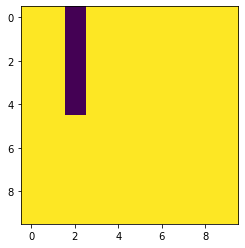

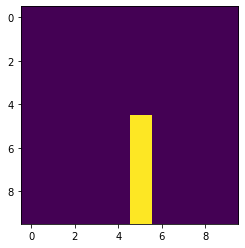

Parameter containing:
tensor([[[ 4.5694e-10, -6.1508e-10, -1.4139e+00, -1.0266e-08,  1.3903e-08,
          -7.1564e-08,  7.2869e-10, -2.4956e-09,  4.6831e-07, -3.1271e-09],
         [ 4.6086e-10, -6.0924e-10, -1.4139e+00, -1.0136e-08,  1.3946e-08,
          -7.1795e-08,  7.6841e-10, -2.5046e-09,  4.6591e-07, -3.1515e-09],
         [ 4.1141e-10, -5.8012e-10, -1.4139e+00, -1.0205e-08,  1.3799e-08,
          -7.1750e-08,  7.1722e-10, -2.5310e-09,  4.6706e-07, -3.0887e-09],
         [ 4.5465e-10, -5.9029e-10, -1.4139e+00, -1.0217e-08,  1.4011e-08,
          -7.1213e-08,  7.3967e-10, -2.5349e-09,  4.7058e-07, -3.0930e-09],
         [ 4.8850e-10, -6.0739e-10, -1.4139e+00, -1.0342e-08,  1.3778e-08,
          -7.2129e-08,  7.6904e-10, -2.5232e-09,  4.7045e-07, -3.0964e-09],
         [-5.7681e-12, -2.1176e-12, -1.1355e-15, -1.4229e-10,  4.2457e-11,
           5.7371e-10,  5.0313e-13, -8.8227e-13, -3.2782e-09,  2.9465e-11],
         [-1.8923e-12,  3.1356e-11, -7.7977e-17, -1.8917e-11, -8.3421e-1

In [18]:
plt.imshow(Us[0].detach()); plt.show()
plt.imshow(Us[1].detach()); plt.show()
Us